Bring down quality of Data

In [5]:
import librosa
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)

from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import librosa.display

import soundfile as sf
import math

import keras
from keras import layers

In [6]:
pathOriginal = 'C:/Users/nhenl/Documents/blueprintHackathon/Nick/clips/original/'
pathReduced = 'C:/Users/nhenl/Documents/blueprintHackathon/Nick/clips/reduced/'
pathShorter = 'C:/Users/nhenl/Documents/blueprintHackathon/Nick/clips/shorter/'

names = [f for f in listdir(pathOriginal) if isfile(join(pathOriginal, f))]
files = [pathOriginal+f for f in listdir(pathOriginal) if isfile(join(pathOriginal, f))]

In [7]:
def scaleData(data):
    std=(data - data.min()) / (data.max() - data.min())
    scaled = std * 1.0
    return scaled

def plot_stft(stft):
    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
    img = librosa.display.specshow(stft, y_axis='linear', x_axis='time',
                                   sr=sr, ax=ax)
    ax.set(title='Linear-frequency power spectrogram')
    ax.label_outer()
    
    fig

In [402]:
num = 640

#Reduce size for testing
names=names[:num]
files=files[:num]

#Lists of spectogram images
x_train= []
y_train =[]
x_test = []
y_test = []

#load all clips
for j in range(0, len(names)):
    y, sr = librosa.load(files[j], duration = 2)
    
    if(j % 50 == 0):
        print(j)
    
    #2 second lengths of all clips
    if librosa.get_duration(y=y, sr=sr) == 2.0:        
        #lower quality using average of every four time series 
        avg = []
        for x in range(0, y.shape[0], 4):
                sum = 0
                if x+4 < y.shape[0]:
                    for i in range(x, x+4):
                        sum += y[i]
                    avg.append(sum/4)
        z = np.array(avg) #np array of time series for clip
        
        #I need to make spectrograms
        S_original =  librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
        S_reduced =  librosa.amplitude_to_db(np.abs(librosa.stft(z)), ref=np.max)
        
        S_origin_pad = np.zeros((1025, 88))
        S_origin_pad[:,:87] = S_original

                        
        #S_original = scaleData(S_original)
        #S_reduced = scaleData(S_reduced)
        
        #img_original = librosa.display.specshow(librosa.amplitude_to_db(S_original, ref=np.max))
        #img_reduced = librosa.display.specshow(librosa.amplitude_to_db(S_reduced, ref=np.max))
        
        if(len(x_train) < (.9 * num)):
            x_train.append(S_reduced) 
            y_train.append(S_origin_pad) 
        else:
            x_test.append(S_reduced)
            y_test.append(S_origin_pad)
            
#sf.write('test.wav', librosa.istft(x_test[0]), 22050) 

0
50
100
150
200
250
300
350
400
450
500
550
600


In [403]:
# print(x_train[0].shape, x_test[0].shape, y_train[0].shape, y_test[0].shape)
# plot_stft()

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [404]:
y_train.shape

(576, 1025, 88)

In [405]:
x_train = (x_train + 80) / 80
y_train = (y_train + 80) / 80
x_test = (x_test + 80) / 80
y_test = (y_test + 80) / 80

x_train = x_train.reshape(*x_train.shape, 1)
y_train = y_train.reshape(*y_train.shape, 1)
x_test = x_test.reshape(*x_test.shape, 1)
y_test = y_test.reshape(*y_test.shape, 1)



In [407]:
import pickle
pickle.dump([x_train, y_train, x_test, y_test], open("dataset640.bin", "wb"))

In [9]:
import pickle
x_train, y_train, x_test, y_test = pickle.load(open("dataset640.bin", "rb"))

In [10]:
encoding_dim = 32
input_img = keras.Input(shape = (1025,22,1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.UpSampling2D((1, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((1, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

encoder = keras.Model(input_img, encoded)
encoder.compile(optimizer='adam', loss='binary_crossentropy')

In [11]:
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1025, 22, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1025, 22, 16)      160       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 1025, 44, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1025, 44, 8)       1160      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 1025, 88, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1025, 88, 8)       584       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1025, 88, 1)       73    

In [12]:
encoder.fit(x_train, y_train,
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_data=(x_test, y_test))

Epoch 1/100
18/18 [==============================] - 5s 86ms/step - loss: 0.6457 - val_loss: 0.4894
Epoch 2/100
18/18 [==============================] - 1s 68ms/step - loss: 0.5522 - val_loss: 0.4326
Epoch 3/100
18/18 [==============================] - 1s 68ms/step - loss: 0.4799 - val_loss: 0.3155
Epoch 4/100
18/18 [==============================] - 1s 67ms/step - loss: 0.4048 - val_loss: 0.2901
Epoch 5/100
18/18 [==============================] - 1s 67ms/step - loss: 0.3927 - val_loss: 0.2915
Epoch 6/100
18/18 [==============================] - 1s 67ms/step - loss: 0.3914 - val_loss: 0.2888
Epoch 7/100
18/18 [==============================] - 1s 68ms/step - loss: 0.3842 - val_loss: 0.2863
Epoch 8/100
18/18 [==============================] - 1s 67ms/step - loss: 0.3856 - val_loss: 0.2846
Epoch 9/100
18/18 [==============================] - 1s 67ms/step - loss: 0.3963 - val_loss: 0.2813
Epoch 10/100
18/18 [==============================] - 1s 67ms/step - loss: 0.3749 - val_loss: 0.2867

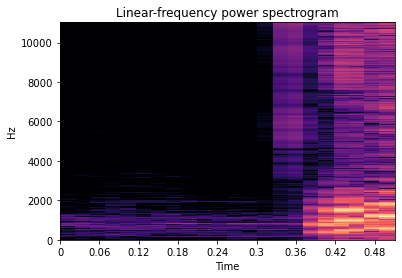

In [34]:
sr=22050
focus = 500
plot_stft(x_train[focus].reshape(1025, 22))

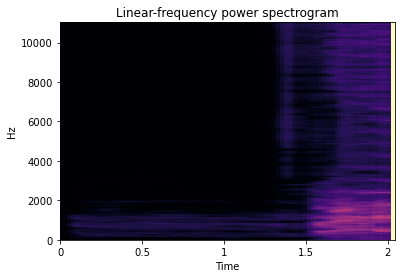

In [35]:
plot_stft(encoder.predict(x_train)[focus].reshape(1025, 88))

In [25]:
# out = encoder.predict(x_train)[focus].reshape(1025, 88)
# out = out * 80 - 80
#out = librosa.db_to_amplitude(out)
oregano_out = librosa.istft(librosa.db_to_amplitude(encoder.predict(x_train)[focus].reshape(1025, 88)[:1022, :] * 80 - 80) * 300)

# oregano_out = y_train[focus].reshape(1025, 88)
# oregano_out = oregano_out * 80 - 80
#oregano_out = librosa.db_to_amplitude(oregano_out)
oregano_out = librosa.istft(librosa.db_to_amplitude(y_train[focus].reshape(1025, 88)[:1022, :] * 80 - 80) * 300)


In [26]:
sf.write('oregano.wav', oregano_out, 22050)
sf.write('insane.wav', librosa.istft(out), 22050)